In [1]:
import pandas as pd
import numpy as np #must be 1.26.4 on python 3.12
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [2]:
#Read in data
df = pd.read_csv('/Users/danayou/Desktop/DS-Case-Study/data/customer.csv')
df = df.head(15000)

In [3]:
#Basic info
num_users = df['CUSTOMER_ID'].nunique()
num_items = df['STOCK_CODE'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")

Number of unique users: 701
Number of unique items: 10172


In [4]:
#Drop zero values in order quantity
df = df[~df['Sales_Order_Quantity'].isin([0.0])]
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,Sales_Order,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name
0,f65441a4f5d7b872ea428bdc27359061,NaN,03/09/2020,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,5d889fa0241b7b92e1d02a6c98ff4232,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...
1,b2b8f192051c662865b33e9045b562cd,NaN,03/08/2022,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,1c73473568f80cd5b22fd233831803c3,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,03/01/2023,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,4298cb0e273806987aff733a183f1328,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,12/01/2021,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,3997d2293c96fd769389a5a3680387ed,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,11/15/2021,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,448b42704b27be4b9594392b86f3f012,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...


In [5]:
#Remove rows with cancelled orders
df = df.drop(df[df['Cancelled_Flag'] == 'False'].index)
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,Sales_Order,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name
0,f65441a4f5d7b872ea428bdc27359061,NaN,03/09/2020,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,5d889fa0241b7b92e1d02a6c98ff4232,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...
1,b2b8f192051c662865b33e9045b562cd,NaN,03/08/2022,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,1c73473568f80cd5b22fd233831803c3,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,03/01/2023,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,4298cb0e273806987aff733a183f1328,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,12/01/2021,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,3997d2293c96fd769389a5a3680387ed,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,11/15/2021,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,448b42704b27be4b9594392b86f3f012,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...


In [6]:
#Make column for return quantity
df['Return_Quantity'] = df['Sales_Order_Quantity'].where(df['Sales_Order_Quantity'] < 0)
df['Return_Quantity'] = df['Return_Quantity'].fillna(0)
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,Sales_Order,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name,Return_Quantity
0,f65441a4f5d7b872ea428bdc27359061,NaN,03/09/2020,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,5d889fa0241b7b92e1d02a6c98ff4232,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...,0.0
1,b2b8f192051c662865b33e9045b562cd,NaN,03/08/2022,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,1c73473568f80cd5b22fd233831803c3,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp,0.0
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,03/01/2023,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,4298cb0e273806987aff733a183f1328,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...,0.0
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,12/01/2021,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,3997d2293c96fd769389a5a3680387ed,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...,0.0
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,11/15/2021,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,448b42704b27be4b9594392b86f3f012,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...,0.0


In [7]:
#Make purchase or return column
df['Purchase_or_Return'] = df['Sales_Order_Quantity'].apply(lambda x: 'Purchase' if x > 0 else 'Return')
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,Sales_Order,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name,Return_Quantity,Purchase_or_Return
0,f65441a4f5d7b872ea428bdc27359061,NaN,03/09/2020,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,5d889fa0241b7b92e1d02a6c98ff4232,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...,0.0,Purchase
1,b2b8f192051c662865b33e9045b562cd,NaN,03/08/2022,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,1c73473568f80cd5b22fd233831803c3,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp,0.0,Purchase
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,03/01/2023,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,4298cb0e273806987aff733a183f1328,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...,0.0,Purchase
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,12/01/2021,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,3997d2293c96fd769389a5a3680387ed,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...,0.0,Purchase
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,11/15/2021,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,448b42704b27be4b9594392b86f3f012,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...,0.0,Purchase


In [8]:
#Make location column
df['Location'] = df['Customer_ShipTo_Addr3'] + ', ' + df['Customer_ShipTo_Addr4']
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,Sales_Order,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name,Return_Quantity,Purchase_or_Return,Location
0,f65441a4f5d7b872ea428bdc27359061,NaN,03/09/2020,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,5d889fa0241b7b92e1d02a6c98ff4232,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...,0.0,Purchase,"HONOLULU, HI"
1,b2b8f192051c662865b33e9045b562cd,NaN,03/08/2022,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,1c73473568f80cd5b22fd233831803c3,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp,0.0,Purchase,"BIDDEFORD, ME"
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,03/01/2023,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,4298cb0e273806987aff733a183f1328,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...,0.0,Purchase,"ANCHORAGE, AK"
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,12/01/2021,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,3997d2293c96fd769389a5a3680387ed,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...,0.0,Purchase,"GRAY, ME"
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,11/15/2021,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,448b42704b27be4b9594392b86f3f012,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...,0.0,Purchase,"GRAY, ME"


In [9]:
#Create df/column for year joined
df['DATE_KEY'] = pd.to_datetime(df['DATE_KEY'], format='%m/%d/%Y')
df['Join_Year'] = df['DATE_KEY'].dt.year
customer_join_year = df.groupby('CUSTOMER_ID')['Join_Year'].min().reset_index()
customer_join_year.rename(columns={'Join_Year': 'Year_Joined'}, inplace=True)

customer_join_year.head()

,CUSTOMER_ID,Year_Joined
0,000b7a1d0f8cbd0403d097dc8acf6732,2020
1,001f3028b94c2406e7b7c7d1d55ef743,2018
2,004bd284af1b1f329213876fcb4debf3,2020
3,005b26ee33b3fd1d7fe307ca022b095b,2022
4,006e6c55c4528104bffe187d062e25f8,2021


In [10]:
#Make profit margin column per product
df['Single_Margin'] = abs(df['Sales_Order_Extended_Margin_Amount'] / df['Sales_Order_Quantity'])
df.head()

,CUSTOMER_ID,Customer_Master_Account_ID,DATE_KEY,Customer_ShipTo_Addr3,Customer_ShipTo_Addr4,STOCK_CODE,Sales_Order_Quantity,Sales_Order_Item_Price,Sales_Order_Extended_Sale_Amount,Sales_Invoice_Number,...,SALES_ORDER_KEY,Sales_Order_Extended_Margin_Amount,Sales_Order_Extended_List_Price_Amount,Cancelled_Flag,Product_Name,Return_Quantity,Purchase_or_Return,Location,Join_Year,Single_Margin
0,f65441a4f5d7b872ea428bdc27359061,NaN,2020-03-09,HONOLULU,HI,42f2127c2763a78382243c3f653e3e7e,10.0,26.68,266.80,37e32447f3c8d536f39470c22c4cb9b8,...,5d889fa0241b7b92e1d02a6c98ff4232,115.80,541.8,NaN,Stainless Steel Glass Beige FoodService Dryer ...,0.0,Purchase,"HONOLULU, HI",2020,11.58
1,b2b8f192051c662865b33e9045b562cd,NaN,2022-03-08,BIDDEFORD,ME,d1f4aa12b9958ac7e8881de4feb119d6,2.0,46.20,92.40,ab4b2aaf42623fc4fb17fa246ff75a80,...,1c73473568f80cd5b22fd233831803c3,15.40,162.0,NaN,Seamless Steel Gray HeatWave Dishwasher Clamp,0.0,Purchase,"BIDDEFORD, ME",2022,7.70
2,165cb4c8e28d9a7dd63ec58f54e12d49,NaN,2023-03-01,ANCHORAGE,AK,5c3cb6dec6751d4ba5c1426554789e20,4.0,39.00,156.00,776afa276779e00793e2ea00a15f9247,...,4298cb0e273806987aff733a183f1328,36.00,240.0,NaN,Quiet Polypropylene Copper GastroTech Coffee M...,0.0,Purchase,"ANCHORAGE, AK",2023,9.00
3,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,2021-12-01,GRAY,ME,7bc5022dbc074cce52d3b986591d5409,1.0,45.02,45.02,0197caed1f6f4bee63ed787b39c604b0,...,3997d2293c96fd769389a5a3680387ed,8.12,84.0,NaN,Ergonomic Carbon Fiber Bronze BrandC Deep Frye...,0.0,Purchase,"GRAY, ME",2021,8.12
4,e55c3852248cf8abf61f8eddfb4c81e0,e55c3852248cf8abf61f8eddfb4c81e0,2021-11-15,GRAY,ME,f1b96ba3745e55ebc58035399b9c1da4,1.0,35.20,35.20,75e8a2d04671f1e4385a49f86403cc80,...,448b42704b27be4b9594392b86f3f012,7.04,38.8,NaN,Adjustable Polypropylene Blue BrandA Coffee Ma...,0.0,Purchase,"GRAY, ME",2021,7.04


Text(0.5, 1.0, 'Most Popular items')

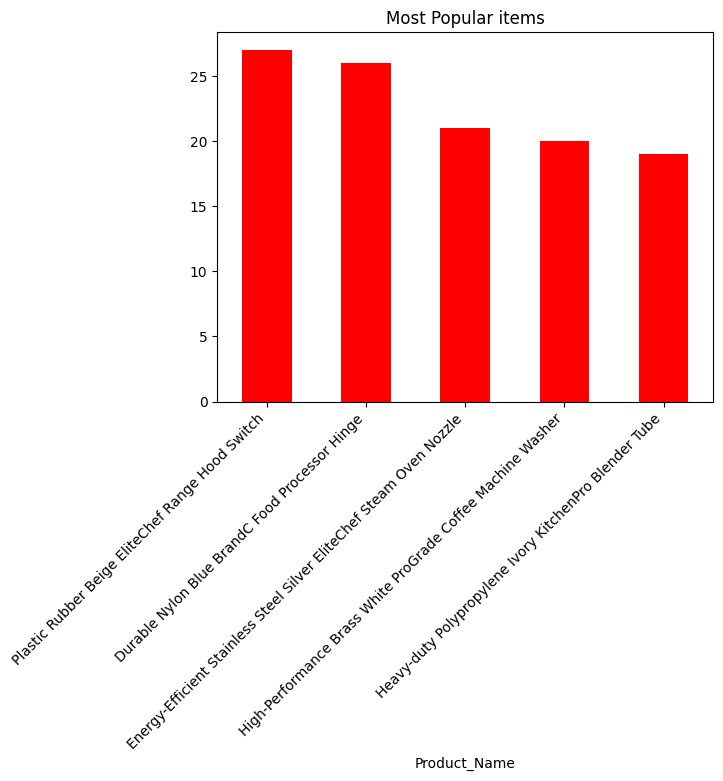

In [11]:
#Plot most popular items
popular_items = df['Product_Name'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.xticks(rotation=45, ha='right')  
plt.title("Most Popular items")

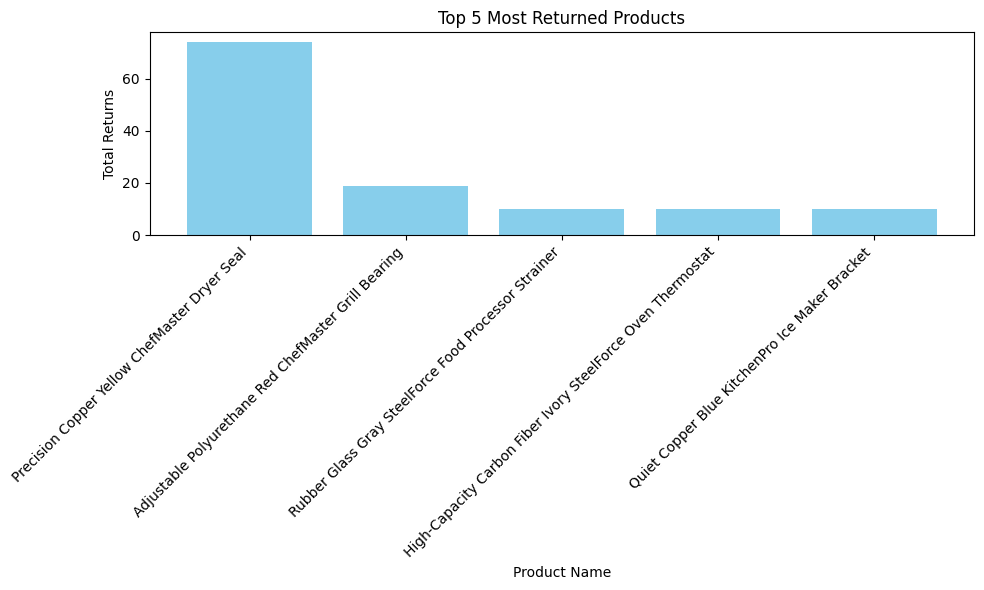

In [12]:
#Plot most returned items
returns_df = df[df['Sales_Order_Quantity'] < 0]

returned_df = returns_df.groupby(['CUSTOMER_ID', 'Product_Name']).agg({
    'Sales_Order_Quantity': 'sum',  
}).reset_index()

returned_df.rename(columns={'Sales_Order_Quantity': 'Returns'}, inplace=True)
returned_df['Returns'] = returned_df['Returns'].abs()

top_returned_products = returned_df.groupby('Product_Name')['Returns'].sum().reset_index()
top_returned_products = top_returned_products.sort_values(by='Returns', ascending=False).head(5)

plt.figure(figsize=(10, 6))
plt.bar(top_returned_products['Product_Name'], top_returned_products['Returns'], color='skyblue')

plt.xlabel('Product Name')
plt.ylabel('Total Returns')
plt.title('Top 5 Most Returned Products')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

In [13]:
#Grouping by customer_id 
result_df = df.groupby(['CUSTOMER_ID', 'Product_Name', 'Purchase_or_Return'], as_index=False).agg({
    'Sales_Order_Quantity': 'sum',
    'Single_Margin': 'mean'        
})

result_df.rename(columns={'Sales_Order_Quantity': 'Total_Quantity'}, inplace=True)
result_df.head()

#Check returns
#result_df[result_df['Purchase_or_Return'] == 'Return']

,CUSTOMER_ID,Product_Name,Purchase_or_Return,Total_Quantity,Single_Margin
0,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Silicone Ivory ChefMaster Mixer Seal,Purchase,2.0,73.83
1,000b7a1d0f8cbd0403d097dc8acf6732,Compact Brass Orange ChefMaster Pizza Oven She...,Purchase,3.0,49.60
2,000b7a1d0f8cbd0403d097dc8acf6732,Durable Aluminum Yellow EliteChef Coffee Machi...,Purchase,1.0,25.88
3,000b7a1d0f8cbd0403d097dc8acf6732,Durable Nylon Red CoolTemp Dryer Bushing,Purchase,1.0,18.78
4,000b7a1d0f8cbd0403d097dc8acf6732,Energy-Efficient Aluminum Bronze BrandB Dryer ...,Purchase,1.0,2.69


In [14]:
#Create weighted values that combine purchase count and profit margin and penalize returns
alpha = 0.6  
beta = 0.4   
penalty_factor = 0.3

result_df['Weighted_Rating'] = np.where(
    result_df['Purchase_or_Return'] == 'Return',
    (alpha * result_df['Total_Quantity'] + beta * result_df['Single_Margin']) * penalty_factor,
    alpha * result_df['Total_Quantity'] + beta * result_df['Single_Margin']
)
result_df.head()

,CUSTOMER_ID,Product_Name,Purchase_or_Return,Total_Quantity,Single_Margin,Weighted_Rating
0,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Silicone Ivory ChefMaster Mixer Seal,Purchase,2.0,73.83,30.732
1,000b7a1d0f8cbd0403d097dc8acf6732,Compact Brass Orange ChefMaster Pizza Oven She...,Purchase,3.0,49.60,21.640
2,000b7a1d0f8cbd0403d097dc8acf6732,Durable Aluminum Yellow EliteChef Coffee Machi...,Purchase,1.0,25.88,10.952
3,000b7a1d0f8cbd0403d097dc8acf6732,Durable Nylon Red CoolTemp Dryer Bushing,Purchase,1.0,18.78,8.112
4,000b7a1d0f8cbd0403d097dc8acf6732,Energy-Efficient Aluminum Bronze BrandB Dryer ...,Purchase,1.0,2.69,1.676


In [15]:
#Encode customer id & products to numerical indices
customer_encoder = LabelEncoder()
product_encoder = LabelEncoder()

result_df['Customer_Index'] = customer_encoder.fit_transform(result_df['CUSTOMER_ID'])
result_df['Product_Index'] = product_encoder.fit_transform(result_df['Product_Name'])
result_df.head()

,CUSTOMER_ID,Product_Name,Purchase_or_Return,Total_Quantity,Single_Margin,Weighted_Rating,Customer_Index,Product_Index
0,000b7a1d0f8cbd0403d097dc8acf6732,Adjustable Silicone Ivory ChefMaster Mixer Seal,Purchase,2.0,73.83,30.732,0,363
1,000b7a1d0f8cbd0403d097dc8acf6732,Compact Brass Orange ChefMaster Pizza Oven She...,Purchase,3.0,49.60,21.640,0,469
2,000b7a1d0f8cbd0403d097dc8acf6732,Durable Aluminum Yellow EliteChef Coffee Machi...,Purchase,1.0,25.88,10.952,0,1252
3,000b7a1d0f8cbd0403d097dc8acf6732,Durable Nylon Red CoolTemp Dryer Bushing,Purchase,1.0,18.78,8.112,0,1443
4,000b7a1d0f8cbd0403d097dc8acf6732,Energy-Efficient Aluminum Bronze BrandB Dryer ...,Purchase,1.0,2.69,1.676,0,2053


In [16]:
#Pivot product_name column and insert weighted_ratings as values
pivot_df = result_df.pivot_table(
    index='CUSTOMER_ID',      
    columns='Product_Name',     
    values='Weighted_Rating',   
    fill_value=0               
)

pivot_df.head()

Product_Name,Adjustable Aluminum Beige CoolTemp Steam Oven Washer,Adjustable Aluminum Black BrandB Ice Maker Nozzle,Adjustable Aluminum Black ProGrade Range Hood Spout,Adjustable Aluminum Blue EliteChef Deep Fryer Heater,Adjustable Aluminum Blue HeatWave Range Hood Clamp,Adjustable Aluminum Blue PureServe Sink Cap,Adjustable Aluminum Blue SmartCook Food Processor Faucet,Adjustable Aluminum Gray BrandA Oven Heater,Adjustable Aluminum Gray ChefMaster Dryer Bushing,Adjustable Aluminum Gray FoodService Steam Oven Faucet,...,Waterproof Steel Matte Black FoodService Blender Drain,Waterproof Steel Matte Black GastroTech Refrigerator Faucet,Waterproof Steel Matte Black KitchenPro Dishwasher Drain,Waterproof Steel Matte Black SmartCook Dishwasher Switch,Waterproof Steel Red ProGrade Sink Switch,Waterproof Steel Transparent FoodService Refrigerator Bushing,Waterproof Steel Transparent ProGrade Sink Strainer,Waterproof Steel Transparent QuickSeal Deep Fryer Latch,Waterproof Steel White BrandB Ice Maker Latch,Waterproof Steel Yellow KitchenPro Convection Oven Heater
CUSTOMER_ID,,,,,,,,,,,,,,,,,,,,,
000b7a1d0f8cbd0403d097dc8acf6732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001f3028b94c2406e7b7c7d1d55ef743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004bd284af1b1f329213876fcb4debf3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005b26ee33b3fd1d7fe307ca022b095b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006e6c55c4528104bffe187d062e25f8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#Mask interactions to create training set
train_df = pivot_df.copy()
validation_df = pivot_df.copy()
mask_percentage = 0.2

for col in train_df.columns:
        mask = np.random.rand(len(train_df)) < mask_percentage
        train_df.loc[mask, col] = 0.0

train_df.head()

Product_Name,Adjustable Aluminum Beige CoolTemp Steam Oven Washer,Adjustable Aluminum Black BrandB Ice Maker Nozzle,Adjustable Aluminum Black ProGrade Range Hood Spout,Adjustable Aluminum Blue EliteChef Deep Fryer Heater,Adjustable Aluminum Blue HeatWave Range Hood Clamp,Adjustable Aluminum Blue PureServe Sink Cap,Adjustable Aluminum Blue SmartCook Food Processor Faucet,Adjustable Aluminum Gray BrandA Oven Heater,Adjustable Aluminum Gray ChefMaster Dryer Bushing,Adjustable Aluminum Gray FoodService Steam Oven Faucet,...,Waterproof Steel Matte Black FoodService Blender Drain,Waterproof Steel Matte Black GastroTech Refrigerator Faucet,Waterproof Steel Matte Black KitchenPro Dishwasher Drain,Waterproof Steel Matte Black SmartCook Dishwasher Switch,Waterproof Steel Red ProGrade Sink Switch,Waterproof Steel Transparent FoodService Refrigerator Bushing,Waterproof Steel Transparent ProGrade Sink Strainer,Waterproof Steel Transparent QuickSeal Deep Fryer Latch,Waterproof Steel White BrandB Ice Maker Latch,Waterproof Steel Yellow KitchenPro Convection Oven Heater
CUSTOMER_ID,,,,,,,,,,,,,,,,,,,,,
000b7a1d0f8cbd0403d097dc8acf6732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001f3028b94c2406e7b7c7d1d55ef743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004bd284af1b1f329213876fcb4debf3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005b26ee33b3fd1d7fe307ca022b095b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006e6c55c4528104bffe187d062e25f8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Create train user-item matrix
train_csr = csr_matrix(train_df.values)
print(train_csr)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 11400 stored elements and shape (701, 10122)>
  Coords	Values
  (0, 363)	30.732
  (0, 469)	21.640000000000004
  (0, 3231)	5.056
  (0, 3272)	5.088
  (0, 3397)	8.488
  (0, 3472)	24.328000000000003
  (0, 7154)	48.032000000000004
  (1, 216)	9.572
  (1, 257)	58.160000000000004
  (1, 319)	27.020000000000003
  (1, 333)	10.399999999999999
  (1, 354)	5.4479999999999995
  (1, 433)	10.479999999999999
  (1, 590)	1.704
  (1, 724)	53.46000000000001
  (1, 1096)	12.688
  (1, 1984)	8.328
  (1, 2574)	64.6
  (1, 3521)	32.832
  (1, 4572)	12.064
  (1, 4606)	6.340000000000001
  (1, 4764)	1.7679999999999998
  (1, 6711)	5.811999999999999
  (1, 7745)	21.792
  (1, 8192)	30.683999999999997
  :	:
  (699, 8303)	11.936
  (699, 8771)	1.1507999999999998
  (699, 8825)	18.240000000000002
  (699, 8827)	1.554
  (699, 9354)	25.656000000000002
  (699, 10043)	2.968
  (700, 153)	3.472
  (700, 474)	3.928
  (700, 1425)	19.080000000000002
  (700, 2090)	6.308
  (700, 

In [19]:
#Create validation user-item matrix
validation_csr = csr_matrix(validation_df.values)
print(validation_csr)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 14277 stored elements and shape (701, 10122)>
  Coords	Values
  (0, 363)	30.732
  (0, 469)	21.640000000000004
  (0, 1252)	10.952
  (0, 1443)	8.112
  (0, 2053)	1.6760000000000002
  (0, 3231)	5.056
  (0, 3272)	5.088
  (0, 3397)	8.488
  (0, 3472)	24.328000000000003
  (0, 6717)	1.48
  (0, 7154)	48.032000000000004
  (0, 7243)	13.372
  (0, 8551)	2.3640000000000003
  (0, 9198)	13.192
  (1, 216)	9.572
  (1, 257)	58.160000000000004
  (1, 319)	27.020000000000003
  (1, 333)	10.399999999999999
  (1, 354)	5.4479999999999995
  (1, 433)	10.479999999999999
  (1, 590)	1.704
  (1, 724)	53.46000000000001
  (1, 1096)	12.688
  (1, 1425)	28.796
  (1, 1984)	8.328
  :	:
  (699, 8827)	1.554
  (699, 9354)	25.656000000000002
  (699, 10043)	2.968
  (700, 153)	3.472
  (700, 474)	3.928
  (700, 659)	0.8799999999999999
  (700, 1425)	19.080000000000002
  (700, 2090)	6.308
  (700, 2641)	8.772
  (700, 3790)	30.240000000000002
  (700, 4219)	22.928000000000004


In [20]:
#Calculate train matrix sparsity
total_elements = train_csr.shape[0] * train_csr.shape[1]
non_zero_elements = train_csr.nnz  
sparsity = (non_zero_elements / total_elements) * 100

print(f"{sparsity}%")

0.1606647121945362%


In [21]:
#Calculate validation matrix sparsity
total_elements = validation_csr.shape[0] * validation_csr.shape[1]
non_zero_elements = validation_csr.nnz  
sparsity = (non_zero_elements / total_elements) * 100

print(f"{sparsity}%")

0.2012114119299468%


In [64]:
#Output (n_samples, n_features)
print("Shape of train_csr:", train_csr.shape) 

Shape of train_csr: (701, 10122)


In [81]:
#Find best parameters using grid search
def explained_variance_scorer(estimator, X, y=None):
    estimator.fit(X)
    return np.sum(estimator.explained_variance_ratio_)  

param_grid = {
    'n_components': [80, 100, 120],  
    'algorithm': ['randomized', 'arpack']
}

svd = TruncatedSVD()

grid_search = GridSearchCV(svd, param_grid, cv=5, scoring=explained_variance_scorer)
grid_search.fit(train_csr)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'algorithm': 'randomized', 'n_components': 120}


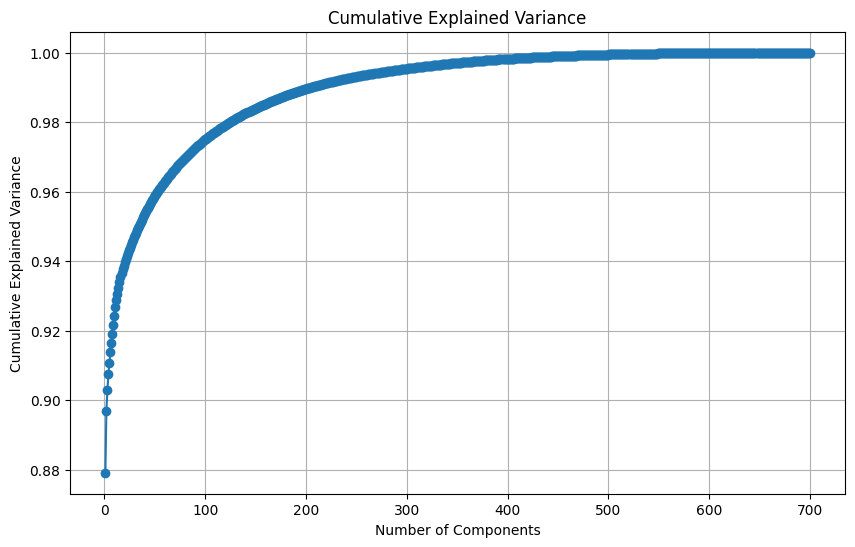

In [23]:
#Plot cumulative explained variance and number of components
svd = TruncatedSVD(n_components=min(train_csr.shape)-1)  
svd.fit(train_csr)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(svd.explained_variance_ratio_) + 1), svd.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [83]:
#Matrix factorization
n_components = 120  
svd = TruncatedSVD(n_components=n_components, random_state=42)

user_features = svd.fit_transform(train_csr)
item_features = svd.components_

predicted_ratings = np.dot(user_features, item_features)

predicted_df = pd.DataFrame(predicted_ratings, index=pivot_df.index, columns=pivot_df.columns)
predicted_df.head()

Product_Name,Adjustable Aluminum Beige CoolTemp Steam Oven Washer,Adjustable Aluminum Black BrandB Ice Maker Nozzle,Adjustable Aluminum Black ProGrade Range Hood Spout,Adjustable Aluminum Blue EliteChef Deep Fryer Heater,Adjustable Aluminum Blue HeatWave Range Hood Clamp,Adjustable Aluminum Blue PureServe Sink Cap,Adjustable Aluminum Blue SmartCook Food Processor Faucet,Adjustable Aluminum Gray BrandA Oven Heater,Adjustable Aluminum Gray ChefMaster Dryer Bushing,Adjustable Aluminum Gray FoodService Steam Oven Faucet,...,Waterproof Steel Matte Black FoodService Blender Drain,Waterproof Steel Matte Black GastroTech Refrigerator Faucet,Waterproof Steel Matte Black KitchenPro Dishwasher Drain,Waterproof Steel Matte Black SmartCook Dishwasher Switch,Waterproof Steel Red ProGrade Sink Switch,Waterproof Steel Transparent FoodService Refrigerator Bushing,Waterproof Steel Transparent ProGrade Sink Strainer,Waterproof Steel Transparent QuickSeal Deep Fryer Latch,Waterproof Steel White BrandB Ice Maker Latch,Waterproof Steel Yellow KitchenPro Convection Oven Heater
CUSTOMER_ID,,,,,,,,,,,,,,,,,,,,,
000b7a1d0f8cbd0403d097dc8acf6732,0.003430,0.003517,0.007526,0.010984,-0.000246,-2.261302e-15,0.001688,-0.000499,0.001948,-0.000062,...,0.0,0.001795,0.000048,0.0,-0.000360,0.0,-0.004566,0.0,-0.002668,0.000086
001f3028b94c2406e7b7c7d1d55ef743,-0.001976,0.145097,0.004196,-0.017263,-0.004522,-5.035750e-15,0.000953,-0.001454,-0.029347,0.000023,...,0.0,0.005326,0.002396,0.0,-0.001526,0.0,-0.027795,0.0,0.011236,0.049106
004bd284af1b1f329213876fcb4debf3,-0.009340,0.004398,-0.012128,0.000336,-0.000847,-9.634058e-16,-0.000004,-0.000204,-0.003123,-0.000084,...,0.0,-0.002050,0.000051,0.0,0.000169,0.0,0.015592,0.0,0.000023,0.054813
005b26ee33b3fd1d7fe307ca022b095b,0.006460,0.040657,0.000731,0.000224,0.000794,-2.508360e-16,0.000084,0.000141,0.003630,0.000139,...,0.0,-0.000042,0.000338,0.0,-0.000023,0.0,0.001561,0.0,-0.000126,-0.001208
006e6c55c4528104bffe187d062e25f8,-0.002060,-0.013852,0.002441,-0.002579,-0.000471,-7.348385e-17,-0.000401,-0.000016,-0.001559,0.000160,...,0.0,0.001750,-0.001146,0.0,0.000106,0.0,-0.002802,0.0,-0.001278,0.004715


In [84]:
#Generate recommendations 
def get_recommendations(user_id, num_recommendations=10):
    user_row = predicted_df.loc[user_id]
    recommended_products = user_row.sort_values(ascending=False)

    return recommended_products.head(num_recommendations)

get_recommendations('001f3028b94c2406e7b7c7d1d55ef743')

Product_Name
Heat-Resistant Steel Blue GastroTech Microwave Spout               4.006720
Adjustable Stainless Steel Red HeatWave Refrigerator Hinge         3.995150
High-Capacity Polypropylene Transparent SteelForce Toaster Seal    3.739109
Seamless Ceramic Beige ProGrade Mixer Bearing                      3.169133
High-Capacity Stainless Steel Silver SmartCook Steam Oven Fan      2.914045
Shock-Absorbent Fiber Copper BrandB Coffee Machine Knob            2.854157
Industrial Polyurethane Ivory HeatWave Freezer Motor               2.641022
High-Performance Steel Transparent BrandA Coffee Machine Motor     2.476401
Quiet Aluminum Green SteelForce Ice Maker Fan                      2.313036
Compact Steel Yellow HeatWave Refrigerator Thermostat              2.172192
Name: 001f3028b94c2406e7b7c7d1d55ef743, dtype: float64

In [85]:
#Compare with validation set
validation_df.loc['001f3028b94c2406e7b7c7d1d55ef743'][validation_df.loc['001f3028b94c2406e7b7c7d1d55ef743'] != 0]

Product_Name
Adjustable Nylon Gray BrandB Dishwasher Bracket                          9.572
Adjustable Plastic Red CoolTemp Steam Oven Strainer                     58.160
Adjustable Polyurethane White PureServe Range Hood Gasket               27.020
Adjustable Rubber Copper SmartCook Deep Fryer Thermostat                10.400
Adjustable Silicone Beige ProGrade Mixer Nozzle                          5.448
Compact Aluminum Blue KitchenPro Refrigerator Washer                    10.480
Compact Fiber Transparent EliteChef Mixer Bushing                        1.704
Compact Polyurethane Red QuickSeal Mixer Gasket                         53.460
Corrosion-Resistant Polyurethane Green EliteChef Dishwasher Coupling    12.688
Durable Nylon Blue BrandC Food Processor Hinge                          28.796
Eco-Friendly Silicone Ivory QuickSeal Ice Maker Thermostat               8.328
Ergonomic Carbon Fiber White PureServe Espresso Machine Nozzle          64.600
Ergonomic Glass Yellow PureServe Freeze

In [86]:
#Set up data for evaluation
predicted_df_eval = predicted_df.reset_index().melt(id_vars='CUSTOMER_ID', var_name='Product_Name', value_name='Predicted_Rating')
predicted_df_eval = predicted_df_eval.sort_values(by='Predicted_Rating', ascending=False)
predicted_df_eval.head()

,CUSTOMER_ID,Product_Name,Predicted_Rating
5103287,0142fab628746a4b5b4c0880776d4e42,Precision Stainless Steel Bronze FoodService D...,8460.092000
2839758,0142fab628746a4b5b4c0880776d4e42,Heavy-duty Silicone Copper BrandC Sink Bushing,8460.016000
2795842,53b4d84350f6e57e076134746d67cb4b,Heavy-duty Polypropylene Yellow PureServe Conv...,1681.022424
238095,9a9300d5c18fe3e98c0d7d7f4db2eb17,Adjustable Rubber Ivory BrandA Oven Nozzle,981.623590
4381485,4defdc9f3026d04e9f9486935c512b3d,Plastic Fiber Green SmartCook Range Hood Bushing,830.832387


In [87]:
#Check for negative values in predictions
test_df = predicted_df.reset_index().melt(id_vars='CUSTOMER_ID', var_name='Product_Name', value_name='Predicted_Rating')
test_df = test_df.sort_values(by='Predicted_Rating', ascending=True)
test_df.head()

,CUSTOMER_ID,Product_Name,Predicted_Rating
276591,842050f7b1e47fa0a9d2a1ce1584f938,Adjustable Stainless Steel Red HeatWave Refrig...,-39.096026
6290615,c0620b8ad27b85ee62b06f38fffae211,Shock-Absorbent Aluminum Gray KitchenPro Grill...,-34.503991
5715964,0382d10bf26f58bcf41840892170e9dd,Quiet Steel Silver KitchenPro Pizza Oven Clamp,-27.966888
7052910,345aa9e0b7299115257b6242696e23ee,Waterproof Stainless Steel Beige EliteChef Fre...,-25.613805
537519,c33b186c0fc28e51f0bac3681ee63c6b,Compact Silicone Black FoodService Microwave B...,-25.489472


In [88]:
#Set threshold to assign relevant or non-relevant as True or False
threshold = 0
predicted_df_eval['Predicted_Label'] = predicted_df_eval['Predicted_Rating'].apply(lambda x: True if x > threshold else False)
predicted_df_eval.head()

,CUSTOMER_ID,Product_Name,Predicted_Rating,Predicted_Label
5103287,0142fab628746a4b5b4c0880776d4e42,Precision Stainless Steel Bronze FoodService D...,8460.092000,True
2839758,0142fab628746a4b5b4c0880776d4e42,Heavy-duty Silicone Copper BrandC Sink Bushing,8460.016000,True
2795842,53b4d84350f6e57e076134746d67cb4b,Heavy-duty Polypropylene Yellow PureServe Conv...,1681.022424,True
238095,9a9300d5c18fe3e98c0d7d7f4db2eb17,Adjustable Rubber Ivory BrandA Oven Nozzle,981.623590,True
4381485,4defdc9f3026d04e9f9486935c512b3d,Plastic Fiber Green SmartCook Range Hood Bushing,830.832387,True


In [89]:
#Format validation data
actual_df_eval = validation_df.reset_index().melt(id_vars='CUSTOMER_ID', var_name='Product_Name', value_name='Weighted_Rating')
actual_df_eval = actual_df_eval.sort_values(by='Weighted_Rating', ascending=False)
actual_df_eval.head()

,CUSTOMER_ID,Product_Name,Weighted_Rating
5103287,0142fab628746a4b5b4c0880776d4e42,Precision Stainless Steel Bronze FoodService D...,8460.092000
2839758,0142fab628746a4b5b4c0880776d4e42,Heavy-duty Silicone Copper BrandC Sink Bushing,8460.016000
2795842,53b4d84350f6e57e076134746d67cb4b,Heavy-duty Polypropylene Yellow PureServe Conv...,1681.180000
238095,9a9300d5c18fe3e98c0d7d7f4db2eb17,Adjustable Rubber Ivory BrandA Oven Nozzle,981.656000
1331754,c47b3e0548be960dbda9f2f782e9cc75,Eco-Friendly Polypropylene Matte Black BrandC ...,900.130165


In [90]:
#Set threshold for validation data
threshold = 0
actual_df_eval['Actual_Label'] = actual_df_eval['Weighted_Rating'].apply(lambda x: True if x > threshold else False)
actual_df_eval.head()

,CUSTOMER_ID,Product_Name,Weighted_Rating,Actual_Label
5103287,0142fab628746a4b5b4c0880776d4e42,Precision Stainless Steel Bronze FoodService D...,8460.092000,True
2839758,0142fab628746a4b5b4c0880776d4e42,Heavy-duty Silicone Copper BrandC Sink Bushing,8460.016000,True
2795842,53b4d84350f6e57e076134746d67cb4b,Heavy-duty Polypropylene Yellow PureServe Conv...,1681.180000,True
238095,9a9300d5c18fe3e98c0d7d7f4db2eb17,Adjustable Rubber Ivory BrandA Oven Nozzle,981.656000,True
1331754,c47b3e0548be960dbda9f2f782e9cc75,Eco-Friendly Polypropylene Matte Black BrandC ...,900.130165,True


In [91]:
#Check length of table
len(actual_df_eval)

7095522

In [95]:
#Create df with actual and predicted boolean labels
merged_df = actual_df_eval.join(predicted_df_eval, how='inner', lsuffix='_actual', rsuffix='_predicted').reset_index()
merged_df = merged_df[['Actual_Label', 'Predicted_Label']]
                       
merged_df.head()

,Actual_Label,Predicted_Label
0,True,True
1,True,True
2,True,True
3,True,True
4,True,False


In [96]:
#Calculate Precision@K for 10
def precision_at_k(df, k):
    df = df.head(k)
    denominator = df['Predicted_Label'].sum()
    numerator = df[df['Predicted_Label'] & df['Actual_Label']].shape[0]
    value = round(float(numerator / denominator) * 100, 2)
    if denominator > 0:
        return f"{value}%"
    else:
        return None

precision_at_k(merged_df, 10)

'100.0%'

In [97]:
#Precision@k for 100000
precision_at_k(merged_df, 100000)

'24.74%'

In [98]:
#Calculate Recall@K for 10
def recall_at_k(df, k):
    df = df.head(k)
    denominator = df['Actual_Label'].sum()
    numerator = df[df['Predicted_Label'] & df['Actual_Label']].shape[0]
    value = round(float(numerator / denominator) * 100, 2)
    if denominator > 0:
        return f"{value}%"
    else:
        return None

recall_at_k(merged_df, 10)

'90.0%'

In [99]:
#Recall@k for 100000
recall_at_k(merged_df, 100000)

'84.52%'